<a href="https://colab.research.google.com/github/chatwipa-sur/SRCC_detection/blob/main/Teacher_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trian teacher model
- Train CenterNet model with original ground truth label

In [30]:
# Standard library for file and directory operations
import os
from datetime import datetime
import sys

# Library for parsing XML files (used for annotations)
import xml.etree.ElementTree as ET

# Core PyTorch library for tensor operations
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split
import torch.nn as nn
import torchvision

# Library for numerical computations
import numpy as np
import pandas as pd

# Library for data visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm

In [3]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Create Dataset

In [4]:
# Make heatmaps using the utility functions from the centernet repo
# Draw a Gaussian centered at a point on a heatmap
def draw_msra_gaussian(heatmap, center, sigma=2):
  # Total size (radius) of the Gaussian region
  tmp_size = sigma * 6

  # Round the x and y center to nearest int
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)

  # Get heatmap dimensions
  w, h = heatmap.shape[0], heatmap.shape[1]

  # Upper-left and bottom-right corners of the Gaussian patch
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]

  # If Gaussian patch is completely outside the heatmap, return
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap

  # Create a 2D Gaussian
  size = 2 * tmp_size + 1 # Size of the Gaussian patch
  x = np.arange(0, size, 1, np.float32) # x coordinates
  y = x[:, np.newaxis] # y coordinates
  x0 = y0 = size // 2 # Center of the Gaussian
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) # 2D Gaussian formula

  # Compute valid bounds for placing the Gaussian patch on the heatmap
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)

  # Place the Gaussian on the heatmap using max to retain highest intensity
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])

  return heatmap

# Draw a dense regression value map around a center point
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  # Size of the square region
  diameter = 2 * radius + 1
  # Create Gaussian mask
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

  # Convert value to float32 and reshape to [dim, 1, 1]
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]

  # Create a repeated value map of shape [dim, H, W]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  # If it's an offset, adjust the values using distance from center
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)

  # Center coordinates
  x, y = int(center[0]), int(center[1])

  # Heatmap dimensions
  height, width = heatmap.shape[0:2]

  # Compute boundaries (clipping at image edges)
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  # Crop regions from heatmap, regmap, Gaussian, and value maps
  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  # Only update if region is valid (non-zero size)
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug

    # Create a mask where Gaussian is stronger than existing heatmap
    idx = (masked_gaussian >= masked_heatmap).reshape(1, masked_gaussian.shape[0],
                                                      masked_gaussian.shape[1])

    # Update regmap only where mask is True (using Gaussian gate)
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg

  # Write updated region back to original regmap
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap

  return regmap

def gaussian2D(shape, sigma=1):
    # Get center and coordinate grid
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    # Apply 2D Gaussian function
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))

    # Remove near-zero values for stability
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h

def make_hm_regr(target, input_size=512, MODEL_SCALE=4):

    IN_SCALE = 1
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)
    # make regr heatmap
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)

    if target.empty:
        return hm, regr

    center = np.array([target["x"] + target["w"]//2, target["y"] + target["h"]//2,
                       target["w"], target["h"]]).T

    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE,
                                     int(c[1])//MODEL_SCALE//IN_SCALE],
                                sigma=np.clip(c[2]*c[3]//2000, 2, 4))

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i,
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;

    return hm, regr

def pred2box(hm, regr, thresh=0.99, MODEL_SCALE=4, input_size=512):
    pred = hm > thresh
    pred_center = np.where(pred)
    pred_r = regr[:, pred].T  # Shape: [N, 2] for w, h
    boxes = []
    scores = hm[pred]

    for i, b in enumerate(pred_r):
        cx = pred_center[1][i] * MODEL_SCALE
        cy = pred_center[0][i] * MODEL_SCALE

        w = b[0] * input_size
        h = b[1] * input_size

        x1 = cx - w /2
        y1 = cy - h /2

        arr = np.clip([x1, y1, w, h], 0, input_size)
        boxes.append(arr)

    return np.asarray(boxes), scores


# Assuming `image` is a torch.Tensor of shape (3, H, W)
def unnormalize_tensor(image):
  mean = [0.485, 0.456, 0.406]
  std  = [0.229, 0.224, 0.225]
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  return image

In [5]:
class SignetRingCellPatchCenterNetDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, patch_size=512, transform=None):
    # Initialize parameters
    self.patch_size = patch_size
    self.stride = patch_size//2  # 50% overlap for 512x512 patches
    self.transform = transform
    self.image_information = []

    # Loop over positive and negative folders
    for class_type in ['positive']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      # Iterate over image files in the folder
      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Collect image path
          image_path = os.path.join(full_image_dir, fname)

          # Collect annotation path
          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
          else:
            anno_path = None  # no annotation for negatives

          # Get the size of image
          image = cv2.imread(image_path)
          height, width = image.shape[:2]

          # Generate sliding window patches
          for top in range(0, height - self.patch_size + 1, self.stride):
            for left in range(0, width - self.patch_size + 1, self.stride):
              self.image_information.append({
                  'image_path': image_path,
                  'annotation_path': anno_path,
                  'crop_box': (left, top, left + self.patch_size, top + self.patch_size)
              })

  def __len__(self):
    return len(self.image_information) # Total number of patches

  def __getitem__(self, idx):
    # Get image for this index
    image_info = self.image_information[idx]
    image = cv2.imread(image_info['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop patch using numpy slicing: [top:bottom, left:right]
    left, top, right, bottom = image_info['crop_box']
    image_patch = image[top:bottom, left:right]

    # Load and process annotations
    boxes_list = []
    if image_info['annotation_path'] is not None:
        tree = ET.parse(image_info['annotation_path'])
        root = tree.getroot()

        crop_xmin, crop_ymin, crop_xmax, crop_ymax = image_info['crop_box']
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'ring_cell_cancer':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                if (xmin >= crop_xmin and xmax <= crop_xmax) and (ymin >= crop_ymin and ymax <= crop_ymax):
                    new_xmin = xmin - crop_xmin
                    new_ymin = ymin - crop_ymin
                    new_xmax = xmax - crop_xmin
                    new_ymax = ymax - crop_ymin
                    boxes_list.append((new_xmin, new_ymin,
                                       new_xmax - new_xmin,
                                       new_ymax - new_ymin))

    # Generate heatmap and regression map as before
    if len(boxes_list) == 0:
        hm = np.zeros([self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
        regr = np.zeros([2, self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
    else:
        target = pd.DataFrame(boxes_list, columns=['x', 'y', 'w', 'h'])
        hm, regr  = make_hm_regr(target)

    # Apply transforms if any
    if self.transform:
        image_patch = self.transform(image_patch)

    return image_patch, hm, regr, boxes_list

#### Visualize dataset
- Check `SignetRingCellPatchDataset` function

In [6]:
# Transform function
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy to PIL
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path of dataset
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

# Load dataset and patching
dataset = SignetRingCellPatchCenterNetDataset(image_dir, annotation_dir, transform=transform)

torch.Size([3, 512, 512])


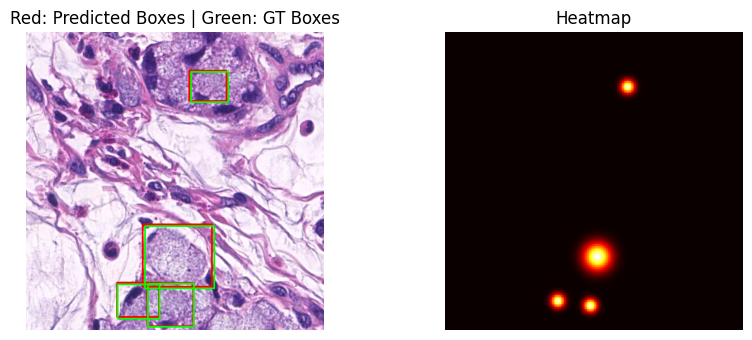

In [17]:
# Get image and corresponding data from dataset
image, hm, regr, gt_boxes = dataset[15]
print(image.shape)  # (3, H, W) – check image size

# Unnormalize image (if normalized during preprocessing)
image = unnormalize_tensor(image.clone())

# Get predicted boxes from heatmap and regression outputs
pred_boxes, _ = pred2box(hm, regr)

# Convert tensor image to numpy
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Copy image for drawing boxes
image_copy = image.copy()

# Draw predicted boxes in red
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw ground truth boxes in green
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Create subplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

# Display image with predicted and GT boxes
axs[0].imshow(image_copy)
axs[0].set_title("Red: Predicted Boxes | Green: GT Boxes")
axs[0].axis('off')

# Display raw heatmap
axs[1].imshow(hm, cmap='hot')
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

torch.Size([3, 512, 512])


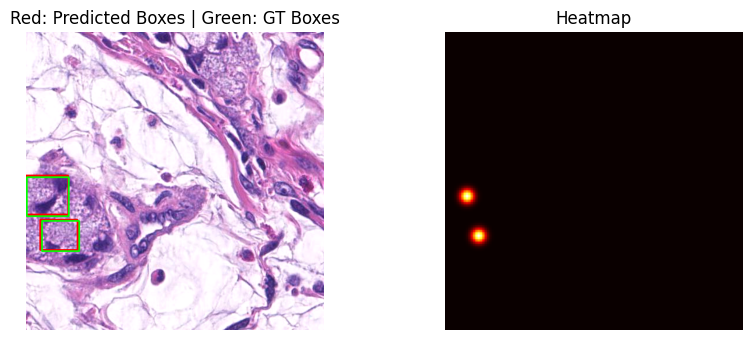

In [16]:
# Get image and corresponding data from dataset
image, hm, regr, gt_boxes = dataset[10]
print(image.shape)  # (3, H, W) – check image size

# Unnormalize image (if normalized during preprocessing)
image = unnormalize_tensor(image.clone())

# Get predicted boxes from heatmap and regression outputs
pred_boxes, _ = pred2box(hm, regr)

# Convert tensor image to numpy
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Copy image for drawing boxes
image_copy = image.copy()

# Draw predicted boxes in red
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw ground truth boxes in green
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Create subplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

# Display image with predicted and GT boxes
axs[0].imshow(image_copy)
axs[0].set_title("Red: Predicted Boxes | Green: GT Boxes")
axs[0].axis('off')

# Display raw heatmap
axs[1].imshow(hm, cmap='hot')
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 2. Create DataLoader

In [19]:
# Transform function
transform = transforms.Compose([
    transforms.ToTensor()
])

# Paths
dataset_base_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset"

# Train and Validation dataset
train_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "train"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/train"),
    transform=transform
)

val_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "val"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/val"),
    transform=transform
)

# Test dataset
test_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "test"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/test"),
    transform=transform
)

# Define a custom collate function to handle the variable-length gt_boxes
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    hms = torch.stack([torch.from_numpy(item[1]).float() for item in batch])
    regrs = torch.stack([torch.from_numpy(item[2]).float() for item in batch])
    gt_boxes = [item[3] for item in batch]

    return images, hms, regrs, gt_boxes

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

Check `train_loader` function

In [20]:
for batch in train_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


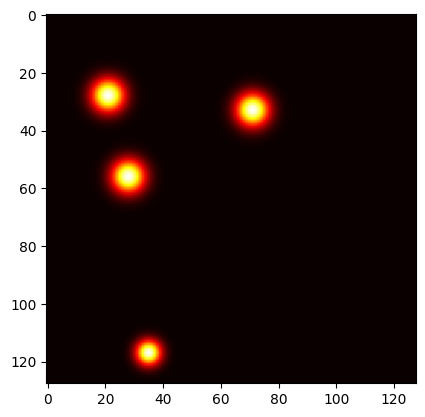

In [23]:
plt.imshow(hm[0], cmap='hot')

Check `val_loader` function

In [24]:
for batch in val_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


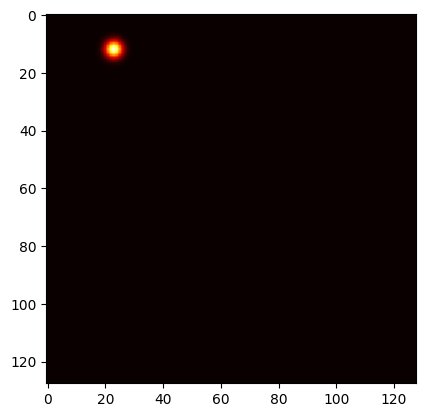

In [25]:
plt.imshow(hm[0], cmap='hot')

Check `test_loader` function

In [26]:
for batch in test_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


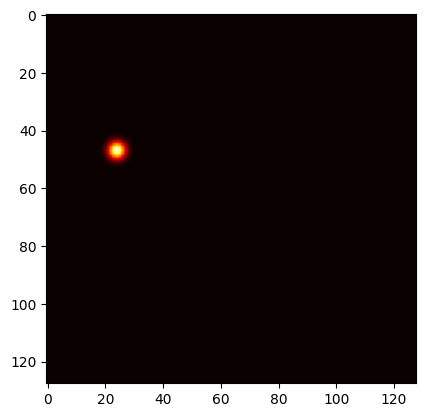

In [28]:
plt.imshow(hm[10], cmap='hot')

## 3. Model Training

### 3.1 CenterNet Model

- The model is based on [CenterNet Baseline](https://www.kaggle.com/hocop1/centernet-baseline/data).

In [31]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18", pretrain = True):
        super(centernet, self).__init__()

        # Create model backbone
        if model_name == "resnet50":
            basemodel = torchvision.models.resnet50(pretrained=pretrain)
            num_ch = 2048
        elif model_name == "resnet34":
            basemodel = torchvision.models.resnet34(pretrained=pretrain)
            num_ch = 512
        elif model_name == "resnet18":
            basemodel = torchvision.models.resnet18(pretrained=pretrain)
            num_ch = 512

        # Remove the last two layers (average pooling and linear layer)
        self.base_model = nn.Sequential(*list(basemodel.children())[:-2])

        # Freeze the backbone
        for param in self.base_model.parameters():
            param.requires_grad = False

        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)

        # Output classification
        self.outc = nn.Conv2d(256, n_classes, 1)

        # Output residue
        self.outr = nn.Conv2d(256, 2, 1)

    def forward(self, x):
        x = self.base_model(x)
        # Add positional info
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outc = torch.sigmoid(outc)
        outr = self.outr(x)
        return outc, outr

### 3.2 Training Function

#### Define loss function

In [60]:
# From centernet repo
# Modified focal loss to detect object centers via heatmap
def neg_loss(pred, gt, pos_gamma=2, neg_gamma=4):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
      Args:
      pred: (B, 1, H, W)
      gt: (B, 1, H, W)
      pos_gamma: focusing parameter for positive examples
      neg_gamma: focusing parameter for negative examples
    '''

  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float() # Locations where there is a true object center
  neg_inds = gt.lt(1).float()  # All other pixels
  neg_weights = torch.pow(1 - gt, 4) # Higher weight for pixels farther from center

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, pos_gamma) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, neg_gamma) * neg_weights * neg_inds

  # pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 3) * pos_inds
  # neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 3) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  num_pos = torch.clamp(num_pos, min=1.0)

  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos

  return loss

# Smooth L1 regression loss for offsets, widths, etc.
def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  #print(gt_regr.size())
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  #print(mask.size())

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)

  return regr_loss


def centerloss(prediction, mask, regr, weight=0.5, size_average=True, eps=1e-6):
    """
    Combines heatmap focal loss and regression L1 loss into a total loss.

    Args:
        prediction: (B, 3, H, W) where [:, 0] = heatmap, [:, 1:] = regr
        mask: (B, H, W) – binary mask for object centers
        regr: (B, 2, H, W) – regression ground truth
        weight: float – weight of regression loss
        size_average: bool – average the final loss across batch
        eps: float – small number to avoid division by zero

    Returns:
        total_loss, mask_loss, regr_loss
    """

    # Heatmap and regression prediction
    pred_mask = torch.sigmoid(prediction[:, 0])  # (B, H, W)
    pred_regr = prediction[:, 1:]                # (B, 2, H, W)

    # Heatmap focal loss
    mask_loss = neg_loss(pred_mask, mask)

    # Regression L1 loss, masked only where mask == 1
    # Use broadcasting: (B, 2, H, W) * (B, 1, H, W)
    mask_exp = mask.unsqueeze(1)  # (B, 1, H, W)
    regr_loss = torch.abs(pred_regr - regr) * mask_exp
    regr_loss = regr_loss.sum(dim=(1, 2, 3)) / (mask_exp.sum(dim=(1, 2, 3)) + eps)
    regr_loss = regr_loss.mean()

    # Combine
    total_loss = mask_loss + regr_loss

    if not size_average:
        total_loss *= prediction.shape[0]

    return total_loss, mask_loss, regr_loss


#### Define train and validation function

In [55]:
def validate():
    # Set model to evaluation mode
    model.eval()

    # Initialize loss value
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0

    # Disable gradient calculations
    with torch.no_grad():  # disable gradient calculations
        for idx, (img, hm_gt, regr_gt, _) in enumerate(val_loader):
            img = img.to(device)
            hm_gt = hm_gt.to(device)
            regr_gt = regr_gt.to(device)

            hm_pred, regr_pred = model(img)

            # Visualization: plot the GT and predicted heatmap for only first batch of epoch
            if idx == 0 and (epoch % 2 == 0 or epoch == 0):
                plt.subplot(1, 2, 1)
                plt.imshow(hm_gt[0].squeeze().cpu().detach().numpy(), cmap='hot')
                plt.title('GT Heatmap')

                plt.subplot(1, 2, 2)
                plt.imshow(torch.sigmoid(hm_pred[0]).squeeze().cpu().detach().numpy(), cmap='hot')
                plt.title('Pred Heatmap')
                plt.show()

            preds = torch.cat((hm_pred, regr_pred), dim=1)
            loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)

            running_loss += loss.item()
            running_mask += mask_loss.item()
            running_regr += regr_loss.item()

    avg_loss = running_loss / len(val_loader)
    avg_mask = running_mask / len(val_loader)
    avg_regr = running_regr / len(val_loader)

    print(f'Validation loss : {avg_loss:.4f}')
    print(f'Validation mask loss : {avg_mask:.4f}')
    print(f'Validation regr loss : {avg_regr:.4f}')

    # Update learning rate scheduler
    scheduler.step(avg_loss)

    return avg_loss, avg_mask, avg_regr

def train(epoch, save_dir):

    # Set model to training mode
    model.train()
    print(f'epochs {epoch + 1}/{epochs}')

    # Initialize loss value
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0

    # Use ASCII and static bar for GitHub/CI support
    t = tqdm(train_loader, file=sys.stdout, dynamic_ncols=True)

    # Iterate over batches
    for idx, (img, hm_gt, regr_gt, _) in enumerate(t):

        # Move batch tensors to the device (GPU or CPU)
        img = img.to(device)
        hm_gt = hm_gt.to(device)
        regr_gt = regr_gt.to(device)

        # Reset gradients for new batch
        optimizer.zero_grad(set_to_none=True)

         # Forward pass: predict heatmap and regression outputs
        hm_pred, regr_pred = model(img)

        # Concatenate heatmap and regression predictions along channel dimension
        preds = torch.cat((hm_pred, regr_pred), dim=1)

        # Compute combined loss (total, mask, and regression)
        loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)

         # Visualization: plot the GT and predicted heatmap for only first batch of epoch
        if idx == 0 and (epoch % 2 == 0 or epoch == 0):
            plt.subplot(1, 2, 1)
            plt.imshow(hm_gt[0].squeeze().cpu().detach().numpy(), cmap='hot')
            plt.title('GT Heatmap')

            plt.subplot(1, 2, 2)
            plt.imshow(torch.sigmoid(hm_pred[0]).squeeze().cpu().detach().numpy(), cmap='hot')
            plt.title('Pred Heatmap')
            plt.show()

        # Backpropagation: compute gradients
        loss.backward()

        # Gradient clipping for stability

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        # Update model weights
        optimizer.step()

        # Accumulate loss values for reporting
        running_loss += loss.item()
        running_mask += mask_loss.item()
        running_regr += regr_loss.item()

         # Compute running average losses for progress bar display
        avg_loss = running_loss / (idx + 1)
        avg_mask = running_mask / (idx + 1)
        avg_regr = running_regr / (idx + 1)

        # Update tqdm progress bar with current average losses
        t.set_postfix(loss=avg_loss, mask=avg_mask, regr=avg_regr)

    # Average losses over the entire epoch after training completes
    print(f'Train loss : {running_loss/len(train_loader):.4f}')
    print(f'Train mask loss : {running_mask/len(train_loader):.4f}')
    print(f'Train regr loss : {running_regr/len(train_loader):.4f}')

    # Run validation after training epoch
    val_loss, val_mask, val_regr = validate()

    # Save full checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss
        }, f'{save_dir}/checkpoint_epoch_{epoch + 1}.pth')

### 3.3 Train model

In [56]:
MODEL_PATH = ''
TRAIN = True

#### RMSprop and RestNet34

In [57]:
# Check if it runs correctly
model = centernet(model_name='resnet34')
model(torch.rand(1,3,512,512))[0].size()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 128, 128])

In [58]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
# Get current timestamp (format: YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create save directory with timestamp
save_dir = f'/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/rmsprop34_checkpoints_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

epochs = 1
if TRAIN:
    for epoch in range(epochs):
        train(epoch, save_dir)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

#### AdamW and RestNet34

In [49]:
# Check if it runs correctly
model = centernet(model_name='resnet34')
model(torch.rand(1,3,512,512))[0].size()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 128, 128])

In [50]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
# Get current timestamp (format: YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create save directory with timestamp
save_dir = f'/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adamw34_checkpoints_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

epochs = 5
if TRAIN:
    for epoch in range(epochs):
        train(epoch, save_dir)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

#### Adam and RestNet34

In [52]:
# Check if it runs correctly
model = centernet(model_name='resnet34')
model(torch.rand(1,3,512,512))[0].size()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 128, 128])

In [53]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
# Get current timestamp (format: YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create save directory with timestamp
save_dir = f'/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adam34_checkpoints_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

epochs = 5
if TRAIN:
    for epoch in range(epochs):
        train(epoch, save_dir)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

### 3.4 Evaluation

In [71]:
model = centernet(model_name='resnet34')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adam34_checkpoints_20250606_093405/checkpoint_epoch_50.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Show prediction

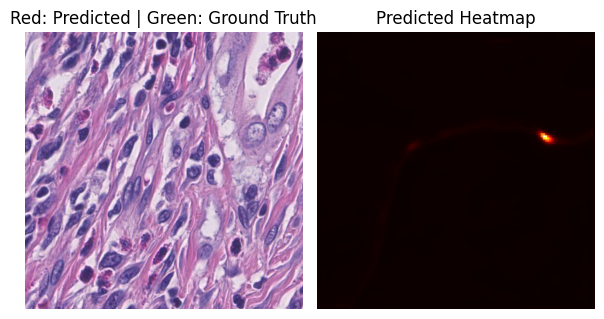

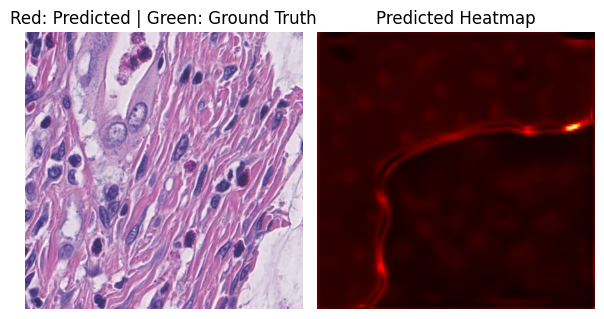

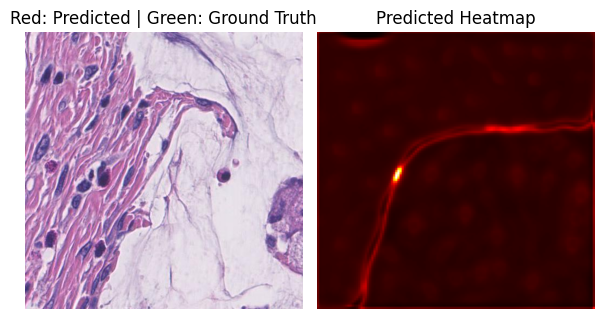

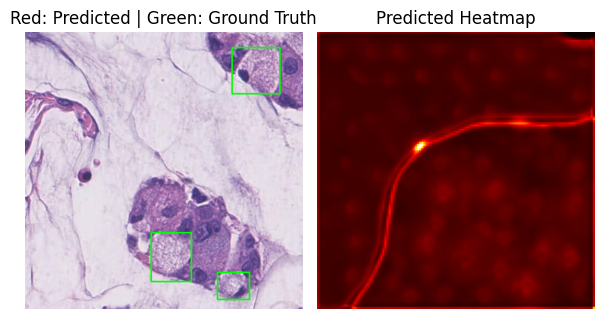

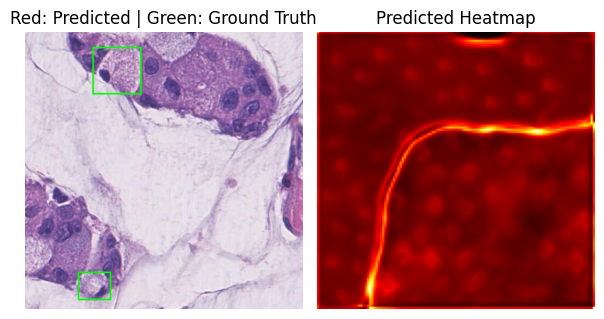

In [72]:
for id in range(5):
    # Get image and ground truth
    image, hm_gt, regr_gt, gt_boxes = test_dataset[id]

    # Get prediction
    with torch.no_grad():
        hm_pred, regr_pred = model(image.to(device).float().unsqueeze(0))
    hm_pred = hm_pred.cpu().numpy().squeeze(0).squeeze(0)
    regr_pred = regr_pred.cpu().numpy().squeeze(0)

    # Get predicted boxes
    pred_boxes, _ = pred2box(hm_pred, regr_pred)

    # Convert image to numpy
    image_np = image.clone().permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)
    image_with_boxes = image_np.copy()

    # Draw predicted boxes (red)
    for box in pred_boxes:
        x, y, w, h = map(int, box)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Draw GT boxes (green)
    for box in gt_boxes:
        x1, y1, w, h = map(int, box)
        cv2.rectangle(image_with_boxes, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

    # --- Create subplot ---
    fig, axs = plt.subplots(1, 2, figsize=(6, 6))

    # Image with boxes
    axs[0].imshow(image_with_boxes)
    axs[0].set_title("Red: Predicted | Green: Ground Truth")
    axs[0].axis("off")

    # Heatmap
    axs[1].imshow(hm_pred, cmap='hot')
    axs[1].set_title("Predicted Heatmap")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

#### Post-processing

In [73]:
# Pool duplicates by applying non-maximum suppression on 3x3 windows
def pool(data):
    stride = 3  # Step size for sliding window

    # Loop over the heatmap with a stride of 3, avoiding borders
    for y in np.arange(1, data.shape[1] - 1, stride):
        for x in np.arange(1, data.shape[0] - 1, stride):

            # Extract a 3x3 neighborhood around the current center (x, y)
            a_2d = data[x - 1:x + 2, y - 1:y + 2]

            # Find the index of the maximum value in the 3x3 window
            max_value = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))

            # Loop over all positions in the 3x3 window
            for c1 in range(3):
                for c2 in range(3):
                    # If the current position is not the maximum, suppress it
                    if not (c1 == max_value[0] and c2 == max_value[1]):
                        data[x + c1 - 1, y + c2 - 1] = -1  # Suppress by setting to -1

    return data  # Return the modified heatmap with non-max values suppressed

In [ ]:
thresh = 0.6
results = []

for img, hm_gt, regr_gt, box_gt in tqdm(test_loader):

    images = img.to(device)
    with torch.no_grad():
        hms_pred, regrs_pred = model(images)

    for img, hm, regr in zip(images, hms_pred, regrs_pred):
        # process predictions
        hm = hm.cpu().numpy().squeeze(0)
        regr = regr.cpu().numpy()
        hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
        hm = pool(hm)

        boxes, scores = pred2box(hm, regr, thresh)

        preds_sorted_idx = np.argsort(scores)[::-1]
        boxes_sorted = boxes[preds_sorted_idx]
        scores_sorted = scores[preds_sorted_idx]

  0%|          | 0/42 [00:00<?, ?it/s]

[] []


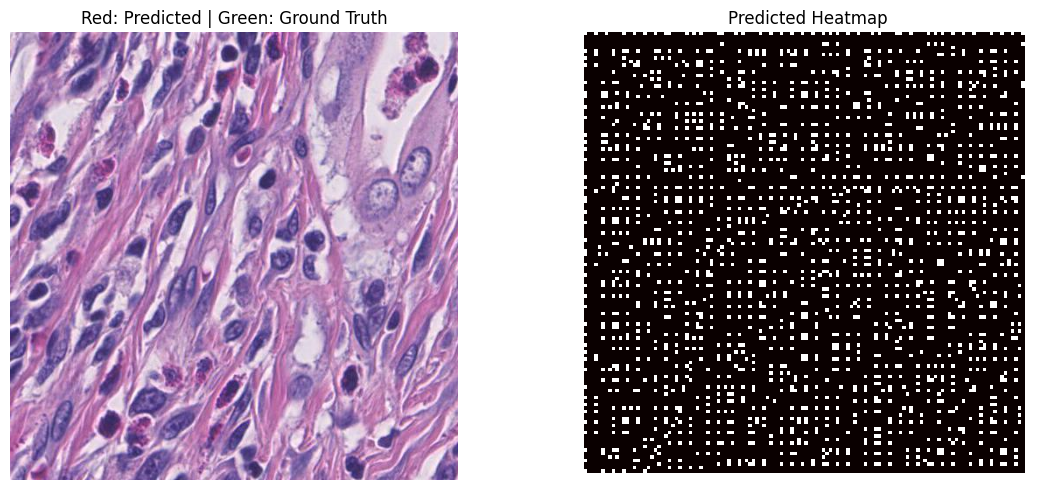

[] []


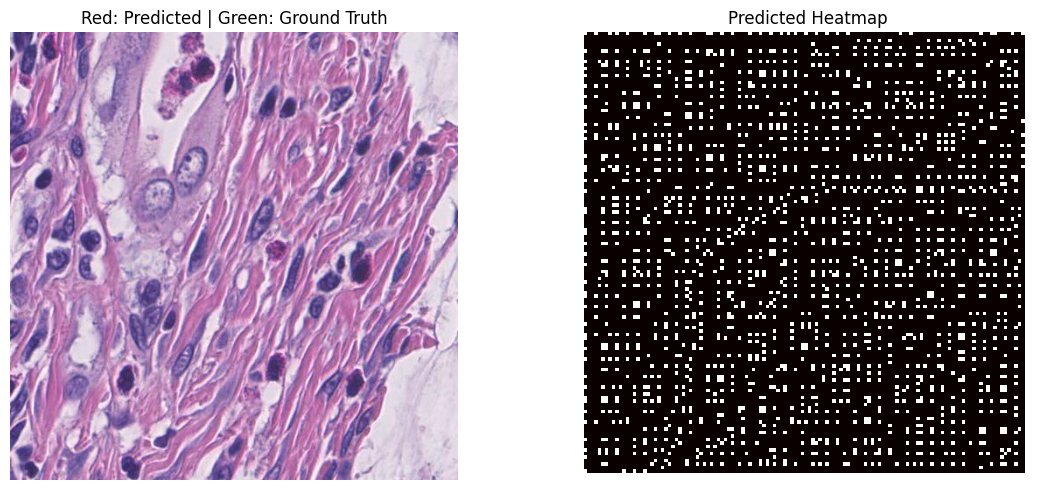

[] []


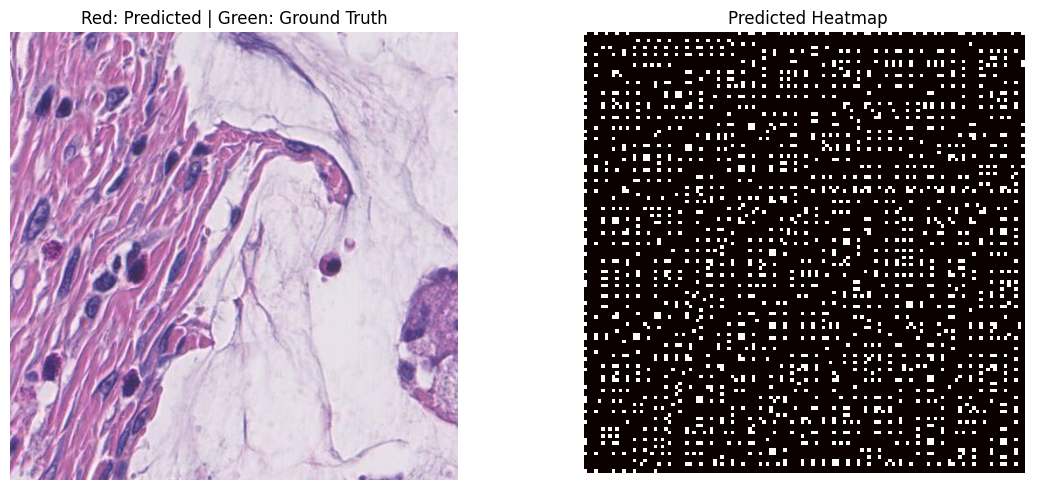

In [85]:
import matplotlib.pyplot as plt
import cv2

# Dummy function to undo normalization (if needed)
def unnormalize_tensor(tensor):
    # Assuming ImageNet normalization, adjust if needed
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(tensor.device)
    return tensor * std + mean

# Start plotting
for img, hm, regr, box_gt in tqdm(test_loader):

    images = img.to(device)

    with torch.no_grad():
        hms_pred, regrs_pred = model(images)

    for i, (img, hm, regr, gt_boxes) in enumerate(zip(images, hms_pred, regrs_pred, box_gt)):

        # Heatmap and regression
        hm = hm.cpu().numpy().squeeze(0)
        regr = regr.cpu().numpy()
        hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
        hm = pool(hm)

        # Predict boxes
        boxes, scores = pred2box(hm, regr, thresh)
        print(boxes, scores)

        # Sort predictions by confidence
        preds_sorted_idx = np.argsort(scores)[::-1]
        boxes_sorted = boxes[preds_sorted_idx]
        scores_sorted = scores[preds_sorted_idx]

        # Unnormalize image and convert for display
        img_disp = img.cpu().clone().permute(1, 2, 0).numpy()
        img_disp = (img_disp * 255).astype(np.uint8)
        img_disp = img_disp.copy()

        # Draw predicted boxes (red)
        for box in boxes_sorted:
            x, y, w, h = map(int, box)
            cv2.rectangle(img_disp, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Draw ground truth boxes (green)
        for box in gt_boxes:
            x, y, w, h = map(int, box)
            cv2.rectangle(img_disp, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Show subplot with image and heatmap
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img_disp)
        plt.title("Red: Predicted | Green: Ground Truth")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(hm, cmap='hot')
        plt.title("Predicted Heatmap")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # Optionally, break early if just visualizing a few
        if i > 1:
            break
    break  # Break outer loop to avoid showing all batches
